# Alaiz NSC benchmark

## Introduction
This script summarizes the overall results of the [Alaiz NSC benchmark](https://thewindvaneblog.com/numerical-site-calibration-benchmark-the-alaiz-case-b3767918d812).

## Load libraries

In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
#import netCDF4 as nc
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
def readExcelToDf(simID):
    # load raw results into pandas
    
    import os
    directory = './outputs/'+simID
    mastName = []
    for filename in os.listdir(directory):
        if filename.endswith(".xlsx") and simID == filename.split('_')[0]:
            filename = filename.replace(simID+'_', '').replace('.xlsx', '')
            mastName.append(filename)

    list_df = []
    # loop on masts
    for k in mastName:

        stab = ['u', 'n', 's']
        filename = './outputs/'+simID+'/'+simID+'_'+k+'.xlsx'
        # loop on stabilities
        for j in range(3):
            
            sheets = ['wind_speed', 'turbulence_intensity']
            variables = dict.fromkeys(sheets)
            for sheet in sheets:
                # read wind speed / turbulence
                try:
                    df_excel = pd.read_excel(open(filename, 'rb'), sheet_name=sheet, usecols="A:K", nrows=6, skiprows=j*8, index_col=None, header=None)
                except:
                    print('Error reading excel:', filename, sheet)
                    return
                sectors = list(df_excel.iloc[0,1:])

                list_df_sheet = []
                # loop on sectors
                for i in range(0, len(sectors)):
                    df_tmp = df_excel.iloc[1:,:].copy()
                    df_tmp['ID'] = simID
                    df_tmp['mast'] = k
                    #df_tmp['mast'] = re.sub('(A.)_SC.', r'\1', k)
                    try:
                        df_tmp['Sector'] = round(sectors[i])
                    except ValueError:
                        print('Error reading excel:', filename, sheet)
                        return
                    df_tmp['Stability'] = stab[j]
                    df_tmp = df_tmp.rename(columns={0:"z", i+1: sheet})[['ID', 'mast', "Sector", "Stability", "z", sheet]]
                    df_tmp.z = df_tmp.z.astype(float)
                    
                    list_df_sheet.append(df_tmp)

                variables[sheet] = pd.concat([a for a in list_df_sheet], axis=0)
                variables[sheet].set_index(['ID', 'mast', 'Sector', 'Stability', 'z'], inplace=True)

            try:
                df_sim = pd.concat([variables[sheet] for sheet in sheets], axis=1)
            except:
                print('Error merging dataframes.')
                return
            list_df.append(df_sim)
    
    return list_df

## Results

### Participants

In [4]:
# Read file with simulation descriptions
sims = pd.read_csv('outputs/alaizNSC_sims.csv', na_filter=False)
sims = sims[sims.Remarks.isin(['Preliminary', 'Revised'])]

n_sim = len(sims)
display(sims)

,ID,Participant,Software Name,Model Name,Number of sectors simulated,Stability modelling,Forest model,Input,"dx, dy [m]",dz [m],L [km],Use time series to transfer wind speed from MP5,Remarks,Label
0,wt168,Huaneng Clean Energy Technology Research Insti...,WT,RANS k-l,,Yes,,Default,,,,,Preliminary,
1,wt324,"SPIC Energy Technology & Engineering Co., Ltd",WT+Mesoscale,RANS k-l,"Ten 10° sectors: 340, …, 20° and 150, …, 190°","Yes (class 1, 2, 6)",,Default,,,11,,Preliminary,
2,wt110,CGN New Energy,WT,RANS k-l,,"Yes (class 1, 2, 6)",,SRTM90m,30,6,12,Yes,Preliminary,
3,wt363,CGN New Energy,WT,RANS k-l,,"Yes (class 1, 2, 6)",,Default,30,6,12,Yes,Preliminary,
4,rans233,N/A,N/A,RANS,,,,Default,,,,,Preliminary,
5,wt194,"Guohua Energy Investment Co.,Ltd",WT,RANS k-l,,Yes,,Default,,,,,Preliminary,
6,wasp949,EDF Renouvelables,Wasp,Linear,"Ten 10° sectors: 340, …, 20° and 150, …, 190°",Calibration using MP5 profile.,Calibration using MP5 profile.,plus tree height for displacement height calcu...,,,,Yes，LT,Preliminary,
7,wt949,EDF Renouvelables,WT,RANS k-l,"Ten 10° sectors: 340, …, 20° and 150, …, 190°","Yes (class 0, 2, 4)",Default WT,Default,10,4,4,Yes，LT,Preliminary,
8,les122,N/A,N/A,LES,11 gestrophic wind directions,via initial and a time varying ground temperature,No,Default,40,20,,Binning based on simulated unsteady wind at MP5,Preliminary,
9,les122a,N/A,N/A,LES,11 gestrophic wind directions,via initial and a time varying ground temperature,No,Default,20,10,,Binning based on simulated unsteady wind at MP5,Revised,


### Load results

In [5]:
list_df = []

simIDs = sims.ID.values

for simID in simIDs:
    list_df += readExcelToDf(simID)

# concatenate all dataframes.
df_sims = pd.concat([a for a in list_df], axis=0)

### Test with xarray Dataset

In [6]:
# convert to xarray dataset.
ds_sims = xr.Dataset.from_dataframe(df_sims)

In [7]:
# Sector 20 missing in les122a 
#ds_sims["wind_speed"].loc[dict(ID='les122a', Sector=20, Stability='n')] = ds_sims["wind_speed"].loc[dict(ID='les122a', Sector=19, Stability='n')]
#ds_sims["turbulence_intensity"].loc[dict(ID='les122a', Sector=20, Stability='n')] = ds_sims["wind_speed"].loc[dict(ID='les122a', Sector=19, Stability='n')]

In [8]:
# define simulation type
simtype = []
for simID in ds_sims.ID.values:
    simtype.append('rans' if ('wt' in simID or 'rans' in simID or 'meteodyn' in simID) else 'les' if 'les' in simID else 'linear' if 'wasp' in simID else '')
ds_sims.coords["simtype"] = ("ID", simtype)

### Flow correction factor (FCF)

In [9]:
ds_sims["flow_correction_factor"] = ds_sims["wind_speed"].copy()
for simID in ds_sims.ID.values:
    print('Processing results of', simID, 'with', df_sims.loc[simID].index.unique('mast').to_list())
    if 'MP5_SC1' in df_sims.loc[simID].index.unique('mast') and 'MP5_SC2' in df_sims.loc[simID].index.unique('mast'):
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast=['A1', 'A2', 'A3', 'MP5_SC2'])] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5_SC2', z=118)]
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast=['A4', 'A5', 'A6', 'MP5_SC1'])] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5_SC1', z=118)]
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5')] = 0.5*(ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5_SC1')] + ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5_SC2')])
        '''
        ds_sims["turbulence_intensity"].loc[dict(ID=simID, mast=['A1', 'A2', 'A3', 'MP5_SC2'])] /= ds_sims["turbulence_intensity"].loc[dict(ID=simID, mast='MP5_SC2', z=118)]
        ds_sims["turbulence_intensity"].loc[dict(ID=simID, mast=['A4', 'A5', 'A6', 'MP5_SC1'])] /= ds_sims["turbulence_intensity"].loc[dict(ID=simID, mast='MP5_SC1', z=118)]
        ds_sims["turbulence_intensity"].loc[dict(ID=simID, mast='MP5')] = 0.5*(ds_sims["turbulence_intensity"].loc[dict(ID=simID, mast='MP5_SC1')] + ds_sims["turbulence_intensity"].loc[dict(ID=simID, mast='MP5_SC2')])
        '''
    elif simID in ['wt110', 'wt363']: # wind speed already converted to FCF for A1-A6
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5')] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5', z=118)]
    else:
        ds_sims["flow_correction_factor"].loc[dict(ID=simID)] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5', z=118)]
        
ds_sims = ds_sims.sel(mast=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5'])

Processing results of les122 with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of les122a with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of rans135aLT with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5', 'MP5_old']
Processing results of rans135bLT with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5', 'MP5_old']
Processing results of rans135cLT with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5', 'MP5_old']
Processing results of rans211 with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of rans233 with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5_SC1', 'MP5_SC2']
Processing results of rans270LT with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of wasp949 with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of wt110 with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of wt168 with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5_SC1', 'MP5_SC2']
Processing results of wt194 with ['A1', 'A2', 'A3', 'A4', 'A5'

### Load observation data

In [10]:
ds_all = ds_sims.copy()
ds_all["Sector"] = ds_sims.Sector.astype(str)

fnList = ['./results/'+a for a in ['A1_SC2.nc', 'A2_SC2.nc', 'A3_SC2.nc', 'A4_SC1.nc', 'A5_SC1.nc', 'A6_SC1.nc']] + ['./inputs/'+a for a in ['MP5_LT.nc']]
obs = dict.fromkeys([fn[0:2] for fn in fnList])
for fn in fnList:
    mast = fn.split('/')[2].split('_')[0]
    obs[mast] = xr.open_dataset(fn)
    obs[mast] = obs[mast].assign_coords(ID='obs')
    obs[mast] = obs[mast].expand_dims('ID')
    obs[mast].coords["simtype"] = ("ID", ['obs'])
    obs[mast] = obs[mast].assign_coords(mast=mast)
    obs[mast] = obs[mast].expand_dims('mast')
    ds_all = xr.merge([ds_all, obs[mast]])

northSectors = ['1', '2', '3', '35', '36']
southSectors = ['16', '17', '18', '19', '20']
norsSectors = northSectors + southSectors
nors = []
for sec in ds_all.coords["Sector"]:
    nors.append('North' if sec in northSectors else 'South' if sec in southSectors else 'Other')
ds_all.coords["nors"] = ("Sector", nors)

# standardize format after merge
ds_all["Sector"] = ds_all.Sector.astype(int)
ds_all = ds_all.sortby(ds_all.Sector, ascending=True)
ds_all["Sector"] = ds_all.Sector.astype(str)

ds_all['samples'] = ds_all.sel(ID='obs')['samples']

#ds_all["turbulence_intensity"].loc[dict(ID='obs')] /= ds_all["turbulence_intensity"].loc[dict(ID='obs', mast='MP5', z=118)]

In [11]:
custom_dict = {'North':0, 'South':1, 'Other':2}
ds_all.sel(mast='MP5')['samples'].to_dataframe().reset_index().groupby(['nors', 'Stability']).sum().reset_index().rename(columns={'nors':'Sector'}).sort_values(by='Sector', key=lambda x : x.map(custom_dict)).set_index(['Sector', 'Stability'])/ds_all.sel(mast='MP5')['samples'].to_dataframe().samples.sum().sum()

samples
Sector Stability          
North  n          0.037101
       s          0.079620
       u          0.385891
South  n          0.038152
       s          0.081949
       u          0.085216
Other  n          0.032443
       s          0.064790
       u          0.194838

## Sector-wise averaged

In [12]:
#'''
# Calculate the weights by grouping by North/South.
weights = ds_all.samples.groupby('nors') /  ds_all.samples.groupby('nors').sum(dim='Sector')

# Test that the sum of the weights for each North/South is 0.0
np.testing.assert_allclose(weights.groupby('nors').sum(dim='Sector').values, np.ones((7,3,3)))

# Calculate the weighted average
ds_weighted = (ds_all * weights).groupby('nors').sum(dim='Sector')
#'''

## Bias calculation

In [13]:
'''
var_fcf = 'flow_correction_factor'
ds_all['error'] = abs(ds_all[var_fcf] - ds_all[var_fcf].sel(ID='obs'))/ds_all[var_fcf].sel(ID='obs')
ds_all['bias'] = (ds_all[var_fcf] - ds_all[var_fcf].sel(ID='obs'))/ds_all[var_fcf].sel(ID='obs')
'''

ds_all['error'] = abs(ds_all['flow_correction_factor'] - ds_all['flow_correction_factor'].sel(ID='obs'))/ds_all['flow_correction_factor'].sel(ID='obs')
ds_all['bias'] = (ds_all['flow_correction_factor'] - ds_all['flow_correction_factor'].sel(ID='obs'))/ds_all['flow_correction_factor'].sel(ID='obs')

ds_weighted['error'] = abs(ds_weighted['flow_correction_factor'] - ds_weighted['flow_correction_factor'].sel(ID='obs'))/ds_weighted['flow_correction_factor'].sel(ID='obs')

ds_error = ds_all.sel(Sector=norsSectors, mast=['A1', 'A2', 'A3', 'A4', 'A5', 'A6'])

### Back to pandas Dateframe for plotting

In [14]:
df_error = ds_error.sel(z=118)[['error', 'bias', 'samples']].to_dataframe()
df_error = df_error.drop(columns=['z'])
df_error = df_error.reset_index()
df_error = df_error[df_error.ID != 'obs']
df_error = df_error[df_error.error.notna()]

df_error = df_error.replace({'Stability': 'u'}, 'Unstable')
df_error = df_error.replace({'Stability': 'n'}, 'Neutral')
df_error = df_error.replace({'Stability': 's'}, 'Stable')

# focus on A1-A6 masts
df_error.mast.value_counts()

A1    449
A4    449
A5    449
A3    449
A2    449
A6    449
Name: mast, dtype: int64

In [15]:
# verification
gp = df_error.groupby(['ID', 'Stability', 'Sector', 'mast'])
df_error['errbis'] = df_error.error * df_error.samples / gp.samples.transform('sum')
df_error['errbis'] = gp['errbis'].transform('sum')
print((df_error.errbis - df_error.error).sum()<1e-5)

# weighted mean error
gp = df_error.groupby(['ID'])
df_error['error_ID'] = df_error.error * df_error.samples / gp.samples.transform('sum')
df_error['error_ID'] = gp['error_ID'].transform('sum')

gp = df_error.groupby(['ID'])
df_error['bias_ID'] = df_error.bias * df_error.samples / gp.samples.transform('sum')
df_error['bias_ID'] = gp['bias_ID'].transform('sum')

gp = df_error.groupby(['ID', 'mast'])
df_error['bias_mast'] = df_error.bias * df_error.samples / gp.samples.transform('sum')
df_error['bias_mast'] = gp['bias_mast'].transform('sum')

gp = df_error.groupby(['ID', 'mast'])
df_error['error_mast'] = df_error.error * df_error.samples / gp.samples.transform('sum')
df_error['error_mast'] = gp['error_mast'].transform('sum')

gp = df_error.groupby(['ID', 'Stability', 'nors', 'mast'])
df_error['error_ns_wt'] = df_error.error * df_error.samples / gp.samples.transform('sum')
df_error['error_ns_wt'] = gp['error_ns_wt'].transform('sum')

gp = df_error.groupby(['ID', 'Stability', 'nors', 'mast'])
df_error['bias_ns_wt'] = df_error.bias * df_error.samples / gp.samples.transform('sum')
df_error['bias_ns_wt'] = gp['bias_ns_wt'].transform('sum')

True


### Plot

In [16]:
# define sort order
custom_dict = {'linear': 1, 'rans': 2, 'les': 3, 'obs' : 0, 'u':0,'n':1,'s':2, 'Unstable':0,'Neutral':1,'Stable':2, '1':1, '2':2, '3':3, '35':35, '36':36, '16':16, '17':17, '18':18, '19':19, '20':20}

            ID     error  error_ID   bias_ID
0   rans135cLT  0.053964  0.051653 -0.035791
1        wt949  0.054905  0.054612 -0.029381
2   rans135aLT  0.060832  0.054631 -0.030916
3   rans135bLT  0.061963  0.055935 -0.031453
4        wt110  0.058849  0.057282 -0.024756
5        wt363  0.059316  0.057545 -0.023700
6      wasp949  0.056420  0.057759 -0.041508
7        wt168  0.062624  0.060015 -0.026204
8    rans270LT  0.060348  0.060236 -0.035336
9        wt194  0.072976  0.063646 -0.026270
10     rans211  0.060102  0.065083 -0.042379
11     rans233  0.071453  0.066569 -0.032053
12       wt324  0.068823  0.067056 -0.025124
13     les122a  0.092969  0.077020  0.004259
14      les122  0.103054  0.089644  0.000982


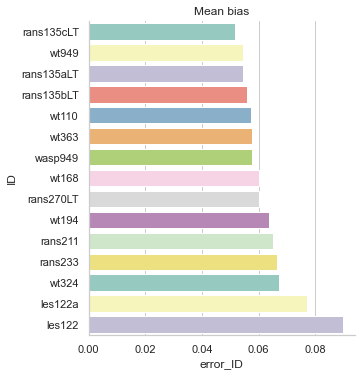

In [17]:
df_plot = df_error.groupby(['ID']).mean().sort_values(by=['error_ID']).reset_index()[['ID', 'error', 'error_ID', 'bias_ID']]
print(df_plot)

sns.set(style="whitegrid")
g = sns.catplot(x="error_ID", y="ID", kind="bar", data=df_plot, palette='Set3')
plt.title("Mean bias")
saved_sort_order = dict((v,k) for k,v in df_plot.ID.to_dict().items())

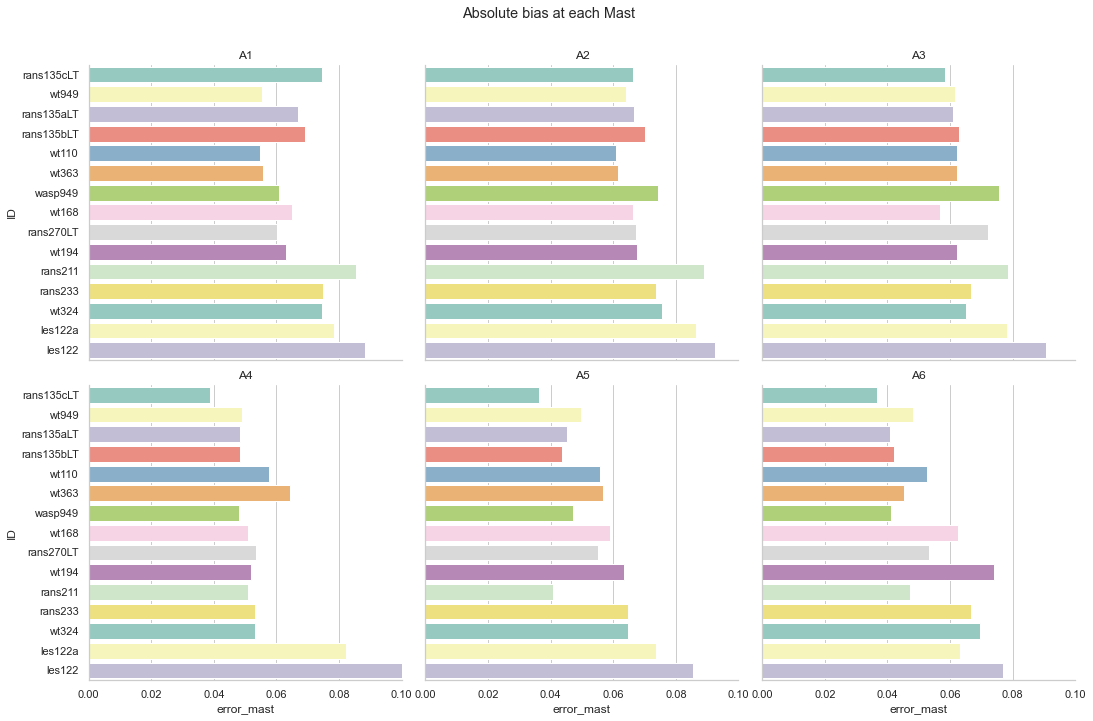

In [18]:
df_plot = df_error.groupby(['ID', 'mast']).mean().reset_index()
df_plot.sort_values(by=['mast', 'ID'], key=lambda x: x.map(saved_sort_order), inplace=True)

g = sns.catplot(x="error_mast", y="ID", col='mast', col_wrap=3, kind="bar", data=df_plot, palette='Set3') #color="#1f77b4")
g.fig.suptitle("Absolute bias at each Mast")
g.fig.subplots_adjust(top=.9)
g.set_titles('{col_name}')
g.set(xlim=(0,0.1))

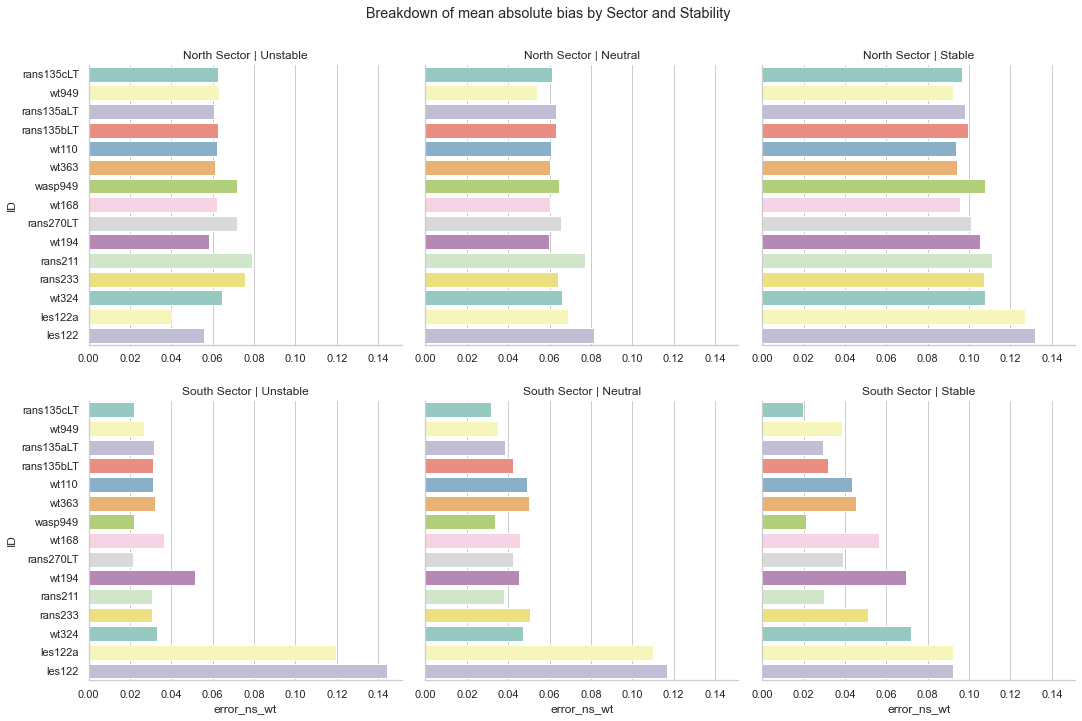

In [19]:
custom_dict.update(saved_sort_order)

df_plot = df_error.groupby(['nors', 'Stability', 'ID']).mean().reset_index()
df_plot.sort_values(by=['nors', 'Stability', 'ID'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.catplot(x="error_ns_wt", y="ID", col='Stability', row='nors', kind="bar", data=df_plot, palette='Set3')
g.fig.suptitle("Breakdown of mean absolute bias by Sector and Stability")
g.fig.subplots_adjust(top=.9)
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)

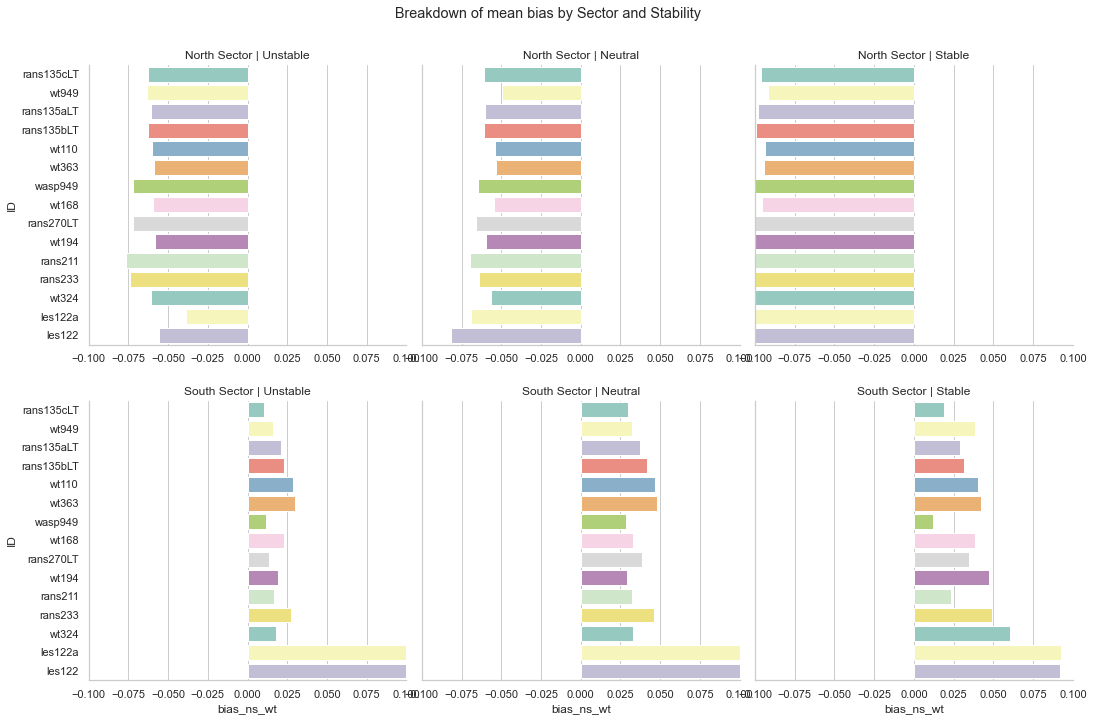

In [20]:
custom_dict.update(saved_sort_order)

df_plot = df_error.groupby(['nors', 'Stability', 'ID']).mean().reset_index()
df_plot.sort_values(by=['nors', 'Stability', 'ID'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.catplot(x="bias_ns_wt", y="ID", col='Stability', row='nors', kind="bar", data=df_plot, palette='Set3')
g.fig.suptitle("Breakdown of mean bias by Sector and Stability")
g.fig.subplots_adjust(top=.9)
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.set(xlim=(-0.1,0.1))

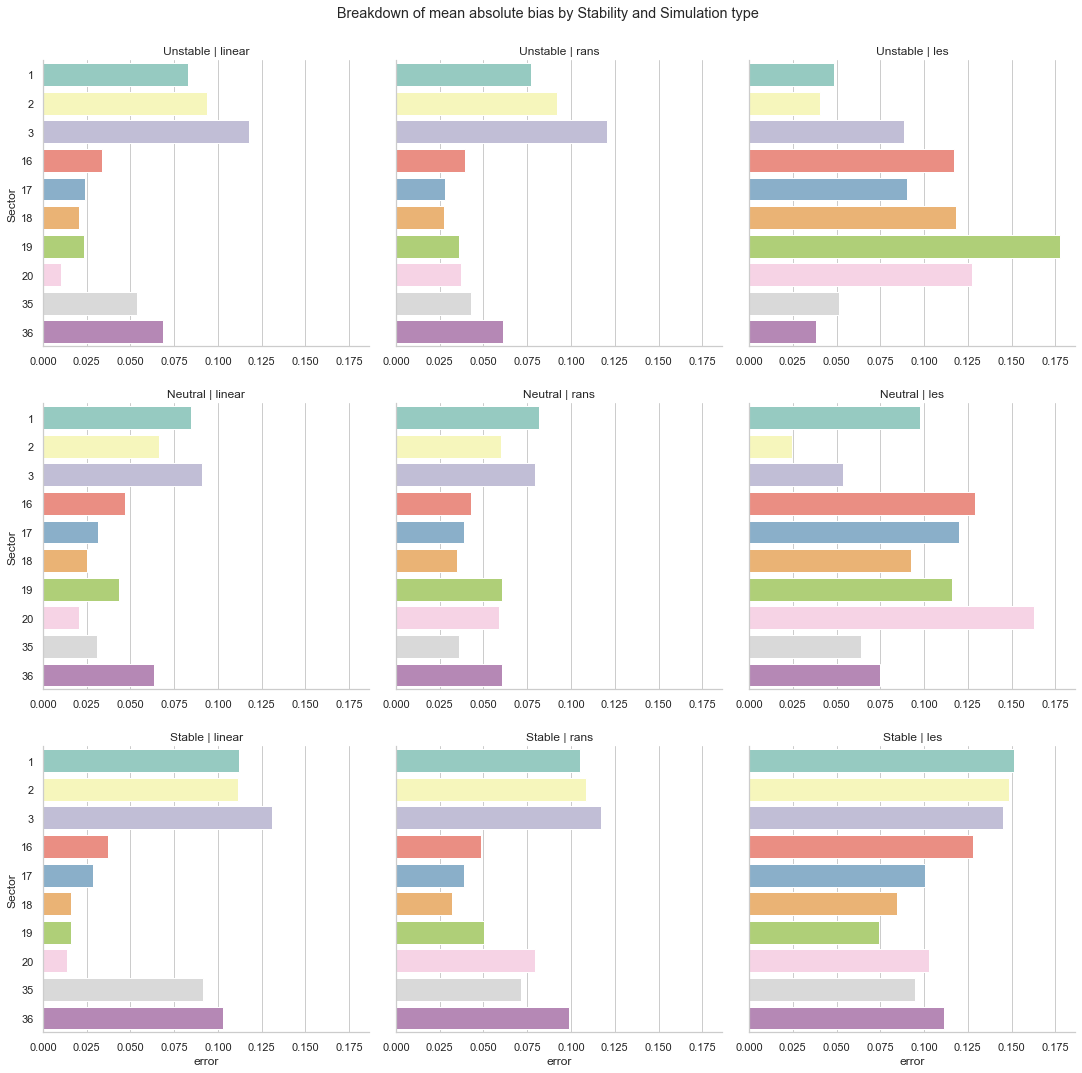

In [21]:
df_plot = df_error.groupby(['simtype', 'Sector', 'Stability']).mean().reset_index()
df_plot.sort_values(by=['simtype', 'Sector', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.catplot(x="error", y="Sector", col='simtype', row='Stability', kind="bar", data=df_plot, palette='Set3')
g.fig.suptitle("Breakdown of mean absolute bias by Stability and Simulation type")
g.fig.subplots_adjust(top=.93)
g.set_titles('{row_name}' ' | ' '{col_name}')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)

## FCF profiles

In [22]:
#df_fcf = ds_all['flow_correction_factor'].to_dataframe()
df_fcf = ds_all[['samples', 'turbulence_intensity', 'flow_correction_factor', 'flow_correction_factor_std']].to_dataframe()
df_fcf = df_fcf.reset_index()
df_fcf = df_fcf[df_fcf.flow_correction_factor.notna()]
df_fcf = df_fcf[df_fcf['nors']!='Other']

df_fcf['standard_error'] = df_fcf['flow_correction_factor_std']/df_fcf['samples'].pow(0.5)

df_fcf = df_fcf.replace({'Stability': 'u'}, 'Unstable')
df_fcf = df_fcf.replace({'Stability': 'n'}, 'Neutral')
df_fcf = df_fcf.replace({'Stability': 's'}, 'Stable')

df_fcf.mast.value_counts()

A4     2395
A2     2395
A3     2365
A1     2365
A5     2365
A6     2365
MP5    2275
Name: mast, dtype: int64

In [23]:
# verification
gp = df_fcf.groupby(['ID', 'mast', 'Sector', 'Stability', 'z'])
df_fcf['fcf_bis'] = df_fcf.flow_correction_factor * df_fcf.samples / gp.samples.transform('sum')
df_fcf['fcf_bis'] = gp.fcf_bis.transform('sum')
print((df_fcf.fcf_bis - df_fcf.flow_correction_factor).describe())

# weighted mean error
gp = df_fcf.groupby(['ID', 'mast', 'nors', 'Stability', 'z'])
df_fcf['fcf_ns'] = df_fcf.flow_correction_factor * df_fcf.samples / gp.samples.transform('sum')
df_fcf['fcf_ns'] = gp.fcf_ns.transform('sum')

count    1.652500e+04
mean     2.351456e-20
std      4.750041e-17
min     -2.220446e-16
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.110223e-16
dtype: float64


### Plot

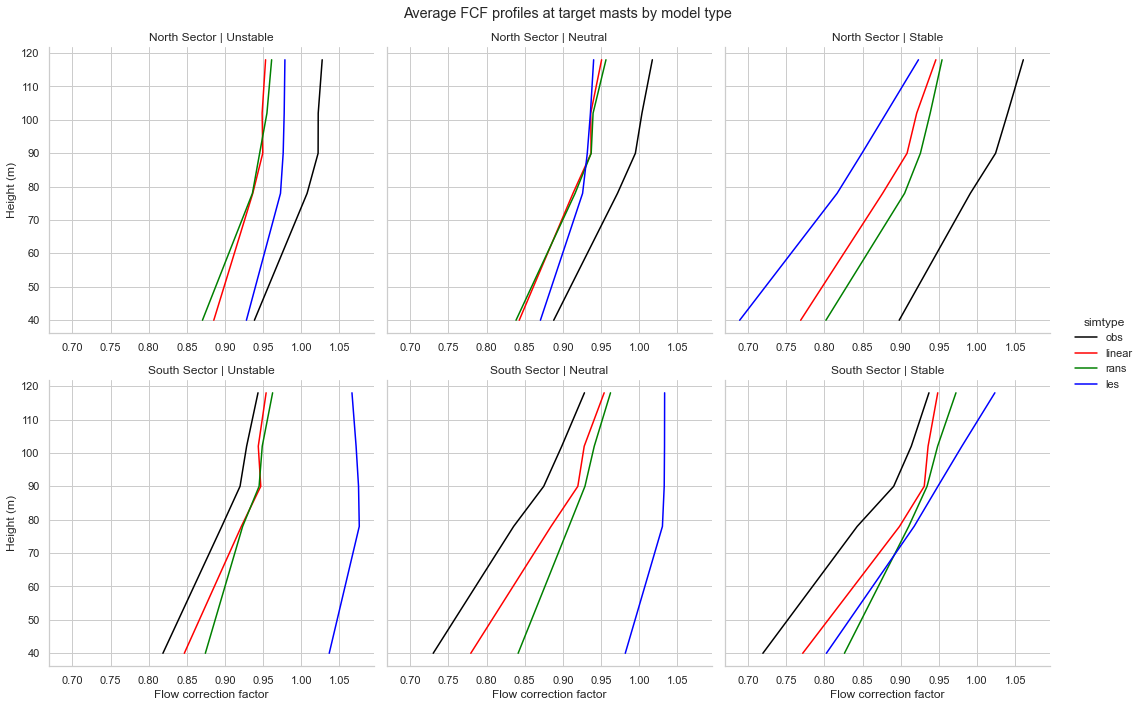

In [24]:
# Create an array with the colors you want to use
colors = ['black', 'red', 'green', 'blue']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

df_plot = df_fcf[df_fcf.mast.isin(['A1', 'A2', 'A3', 'A4', 'A5', 'A6'])].groupby(['simtype', 'z', 'Stability', 'nors']).mean().reset_index()
df_plot.sort_values(by=['simtype', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.relplot(data=df_plot, x="fcf_ns", y="z", sort=False, col='Stability', row='nors', hue='simtype', kind='line', palette = customPalette)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
g.fig.suptitle("Average FCF profiles at target masts by model type")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
#g.savefig("facet_plot.png")

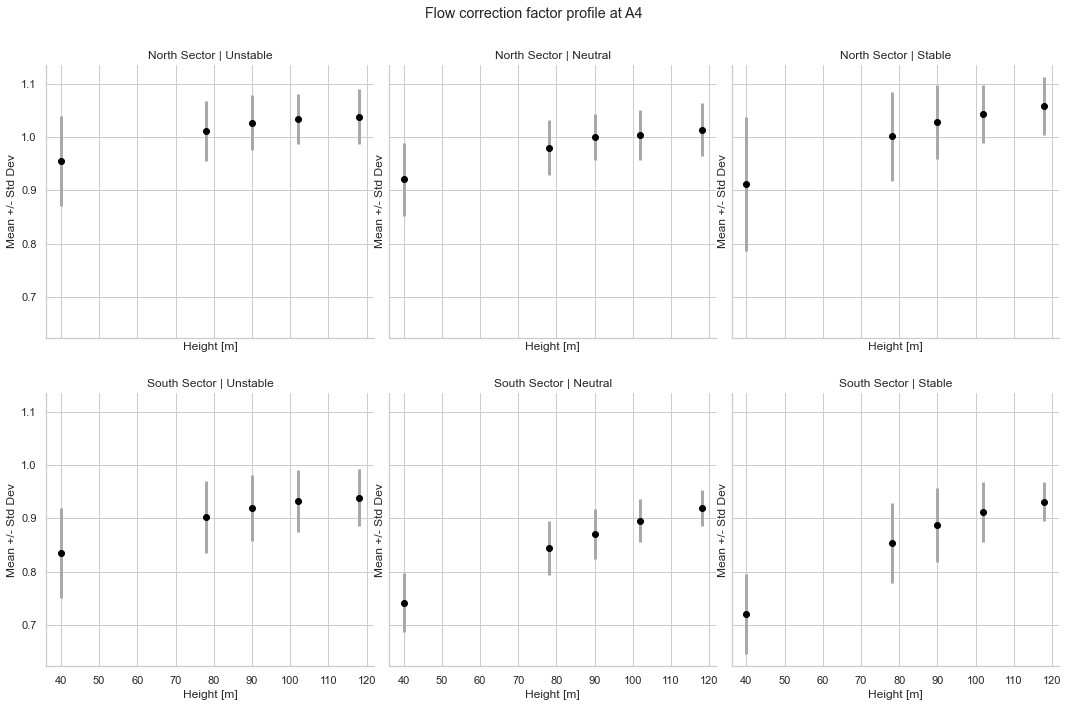

In [25]:
dfplot = df_fcf[(df_fcf.ID=='obs') & (df_fcf.mast=='A4')].groupby(['Stability', 'nors', 'z']).mean().reset_index()
custom_dict = {'obs' : 0, 'Unstable':0,'Neutral':1,'Stable':2, 'MP5':3}
dfplot.sort_values(by=['Stability', 'nors', 'z'], key=lambda x: x.map(custom_dict), inplace=True)
g = sns.FacetGrid(dfplot, col='Stability', row='nors', height=5)
g.map(plt.errorbar, "z", "flow_correction_factor", "flow_correction_factor_std", marker="o", fmt='o', color='black',
             ecolor='darkgray', elinewidth=3, capsize=0)
#g.set(ylabel='Mean +/- SEM')
g.set(ylabel='Mean +/- Std Dev')
g.set(xlabel='Height [m]')
g.set_titles('{row_name} Sector | {col_name}')
g.fig.suptitle("Flow correction factor profile at A4")
g.fig.subplots_adjust(top=.9)
plt.subplots_adjust(hspace = 0.2)

#display(dfplot)

#dfplot = df_fcf[(df_fcf.ID=='obs') & (df_fcf.z==118)].groupby(['nors', 'mast', 'z']).mean()
#dfplot.flow_correction_factor_std/dfplot.flow_correction_factor

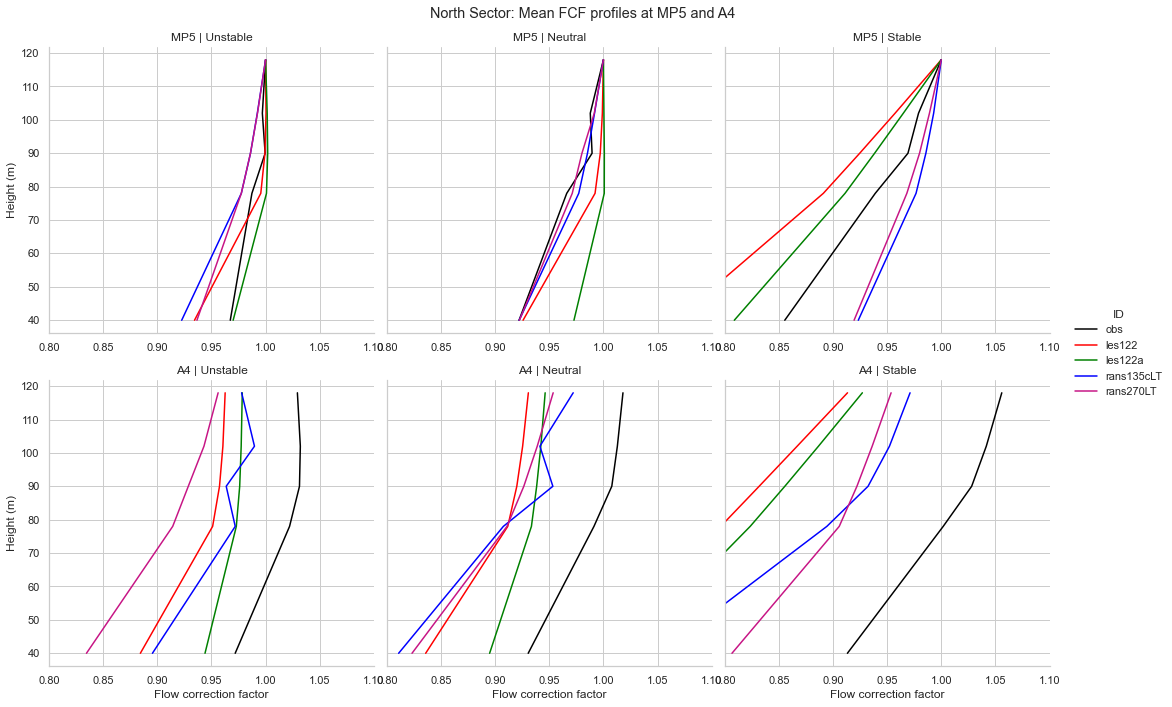

In [26]:
# Create an array with the colors you want to use
colors = ['black', 'red', 'green', 'blue']
colors += ['mediumvioletred','orange', '#16A085', 'mediumblue','#D4AC0D','#808B96','#5DADE2','C2','#A569BD',
               '#641E16', '#A93226','#D98880','#ABB2B9','C0','C1','C3','C4','C5','C6','C7']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

df_plot = df_fcf[df_fcf.ID.isin(['obs', 'les122', 'les122a', 'rans270LT', 'rans135cLT'])]
#df_plot = df_fcf[df_fcf.ID.isin(['obs'])]

df_plot = df_plot[df_plot.nors.isin(['North'])]
df_plot = df_plot[df_plot.mast.isin(['MP5', 'A4'])].groupby(['ID', 'z', 'Stability', 'mast']).mean().reset_index()
custom_dict = {'obs' : 0, 'Unstable':0,'Neutral':1,'Stable':2, 'MP5':3}
df_plot.sort_values(by=['ID', 'Stability', 'mast'], key=lambda x: x.map(custom_dict), inplace=True)

#g = sns.relplot(data=df_plot, x="flow_correction_factor", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, style='ID')
                #, dashes=[(2,0), (4,2), (2,0), (6,4), (1,1)])
g = sns.relplot(data=df_plot, x="fcf_ns", y="z", sort=False, col='Stability', row='mast', hue='ID', kind='line', palette=customPalette, dashes=True)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name}' ' | ' '{col_name}')
g.fig.suptitle("North Sector: Mean FCF profiles at MP5 and A4")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
g.set(xlim=(0.80,1.10))
#g.savefig("facet_plot.png")

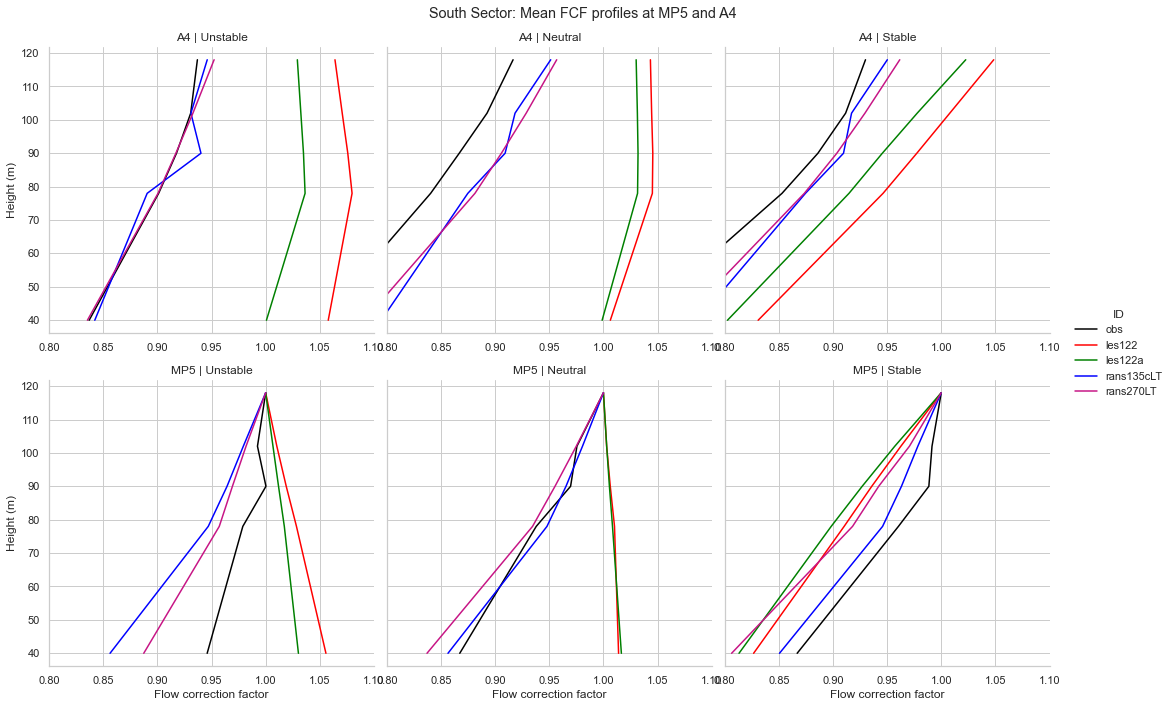

In [27]:
df_plot = df_fcf[df_fcf.ID.isin(['obs', 'les122', 'les122a', 'rans270LT', 'rans135cLT'])]
#df_plot = df_fcf[df_fcf.ID.isin(['obs'])]
df_plot = df_plot[df_plot.nors.isin(['South'])]
df_plot = df_plot[df_plot.mast.isin(['MP5', 'A4'])].groupby(['ID', 'z', 'Stability', 'mast']).mean().reset_index()
custom_dict = {'obs' : 0, 'Unstable':0,'Neutral':1,'Stable':2, 'A4':3, 'MP5':4}
df_plot.sort_values(by=['ID', 'Stability', 'mast'], key=lambda x: x.map(custom_dict), inplace=True)

#g = sns.relplot(data=df_plot, x="flow_correction_factor", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, style='ID')
                #, dashes=[(2,0), (4,2), (2,0), (6,4), (1,1)])
g = sns.relplot(data=df_plot, x="fcf_ns", y="z", sort=False, col='Stability', row='mast', hue='ID', kind='line', palette=customPalette, dashes=True)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name}' ' | ' '{col_name}')
g.fig.suptitle("South Sector: Mean FCF profiles at MP5 and A4")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
g.set(xlim=(0.80,1.10))
#g.savefig("facet_plot.png")

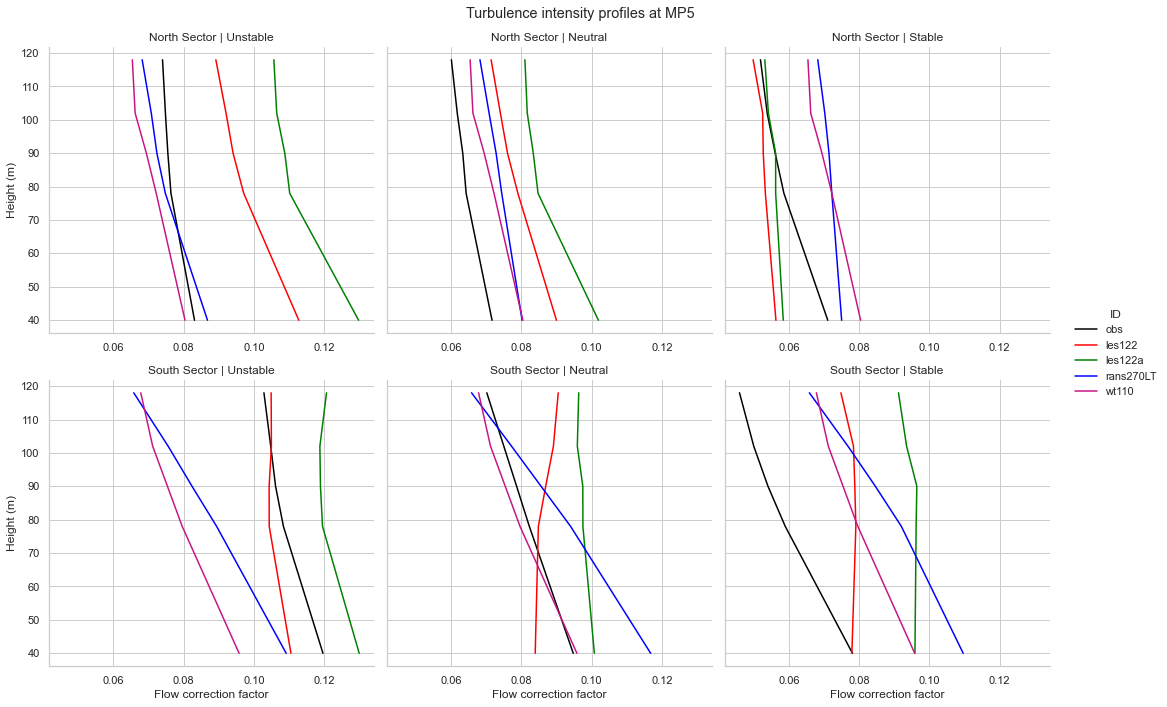

In [28]:
df_plot = df_fcf[df_fcf.ID.isin(['obs', 'les122', 'les122a', 'rans270LT', 'wt110'])]
df_plot = df_plot[df_plot.mast.isin(['MP5'])].groupby(['ID', 'z', 'Stability', 'nors']).mean().reset_index()
custom_dict = {'obs' : 0, 'Unstable':0,'Neutral':1,'Stable':2}
df_plot.sort_values(by=['ID', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

#g = sns.relplot(data=df_plot, x="flow_correction_factor", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, style='ID')
                #, dashes=[(2,0), (4,2), (2,0), (6,4), (1,1)])
g = sns.relplot(data=df_plot, x="turbulence_intensity", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, dashes=True)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
g.fig.suptitle("Turbulence intensity profiles at MP5")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
#g.savefig("facet_plot.png")

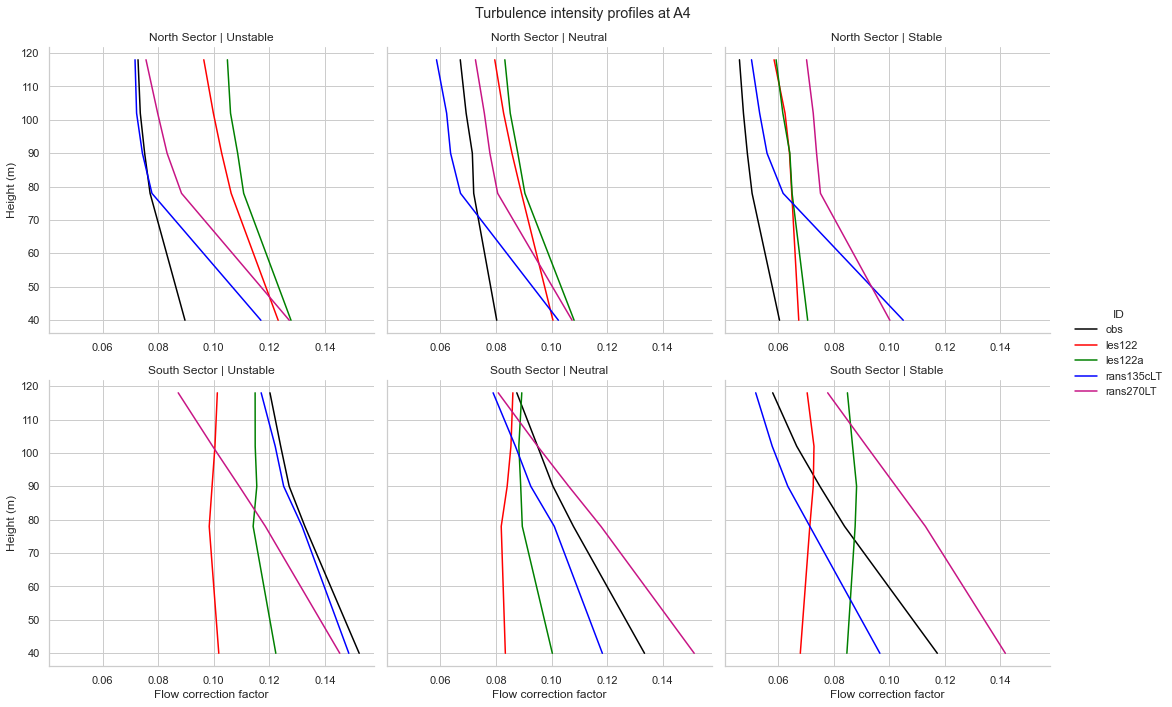

In [29]:
df_plot = df_fcf[df_fcf.ID.isin(['obs', 'les122', 'les122a', 'rans270LT', 'rans135cLT'])]
df_plot = df_plot[df_plot.mast.isin(['A4'])].groupby(['ID', 'z', 'Stability', 'nors']).mean().reset_index()
custom_dict = {'obs' : 0, 'Unstable':0,'Neutral':1,'Stable':2}
df_plot.sort_values(by=['ID', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

#g = sns.relplot(data=df_plot, x="flow_correction_factor", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, style='ID')
                #, dashes=[(2,0), (4,2), (2,0), (6,4), (1,1)])
g = sns.relplot(data=df_plot, x="turbulence_intensity", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, dashes=True)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
g.fig.suptitle("Turbulence intensity profiles at A4")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
#g.savefig("facet_plot.png")